# Workshop 6 

### Outline: 
 
1. Some Background on training
2. The effect of hyperparameters
3. Multi-Class Classifcation: Classifying newswires (Chapter 3)
4. Regression with Deep Learning (Chapter 3)

Source: Deep Learning with Keras, François Chollet, 2017

## Background

### Computational Graph In PyTorch

In [16]:
import torch

# Define input and weights
x = torch.tensor(2.0, requires_grad=True)
w = torch.tensor(3.0, requires_grad=True)

# Forward pass
y = x * w + 1

# Backward pass
y.backward()
print(x.grad)  # Output: 3.0

tensor(3.)


### Batch-Wise Training In PyTorch
Loss Aggregation

In [17]:
import torch
import torch.nn as nn

# Define predictions and targets
predictions = torch.tensor([[0.8, 0.1], [0.4, 0.5]], requires_grad=True)
targets = torch.tensor([0, 1])

# Define CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Compute batch loss
loss = criterion(predictions, targets)
print(loss)

tensor(0.5238, grad_fn=<NllLossBackward0>)


### Example Of Gradient Flow In PyTorch

In [18]:
import torch
import torch.nn as nn

# Define a simple model
model = nn.Linear(2, 1)  # Single layer: y = w * x + b
loss_fn = nn.MSELoss()

# Input and target
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
y = torch.tensor([[5.0], [7.0]])

# Forward pass
pred = model(x)
loss = loss_fn(pred, y)

# Backward pass
loss.backward()

# Gradients
print("Weight gradient:", model.weight.grad)
print("Bias gradient:", model.bias.grad)

Weight gradient: tensor([[-27.5349, -40.3169]])
Bias gradient: tensor([-12.7819])


### Practical Example — Backpropagation With Batches

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(3, 5)  # Input: 3 features, Output: 5 features
        self.fc2 = nn.Linear(5, 1)  # Output: 1 feature (regression task)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleModel()

In [20]:
# Create a batch of input data
batch_size = 4
x_batch = torch.rand(batch_size, 3)  # 4 samples, each with 3 features
y_batch = torch.rand(batch_size, 1)  # 4 target values

print("Input Batch:\n", x_batch)
print("Target Batch:\n", y_batch)

Input Batch:
 tensor([[0.5901, 0.3810, 0.3264],
        [0.2177, 0.4896, 0.8047],
        [0.7914, 0.6613, 0.4044],
        [0.9473, 0.3727, 0.7662]])
Target Batch:
 tensor([[0.8222],
        [0.9673],
        [0.4786],
        [0.0149]])


In [21]:
# Forward pass
y_pred = model(x_batch)
print("Predictions:\n", y_pred)

Predictions:
 tensor([[-0.3874],
        [-0.1667],
        [-0.3960],
        [-0.4391]], grad_fn=<AddmmBackward0>)


In [22]:
# Define the loss function
loss_fn = nn.MSELoss()

# Compute the loss
loss = loss_fn(y_pred, y_batch)
print("Batch Loss:", loss.item())

Batch Loss: 0.9300132989883423


In [23]:
# Backward pass
loss.backward()

# Inspect gradients
print("Gradients for fc1 weights:\n", model.fc1.weight.grad)
print("Gradients for fc2 weights:\n", model.fc2.weight.grad)

Gradients for fc1 weights:
 tensor([[ 0.3819,  0.2513,  0.2280],
        [ 0.0000,  0.0000,  0.0000],
        [-0.0260, -0.0220, -0.0251],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.4004,  0.3390,  0.3861]])
Gradients for fc2 weights:
 tensor([[-0.5302,  0.0000, -0.7085,  0.0000, -0.3206]])


In [24]:
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Update parameters
optimizer.step()

# Zero gradients after the update
optimizer.zero_grad()

In [25]:
# Inspect gradients after zeroing
print("Gradients after zeroing:\n", model.fc1.weight.grad)

Gradients after zeroing:
 None


## The effect of network structure and hyperparameters

Epoch 50/200, Loss: 0.4108
Epoch 100/200, Loss: 0.3448
Epoch 150/200, Loss: 0.3293
Epoch 200/200, Loss: 0.3230
Test Accuracy: 0.875


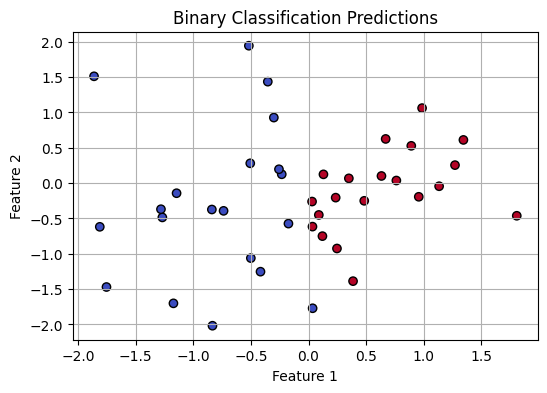

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Generate synthetic binary classification data
X, y = make_classification(
    n_samples=200, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, random_state=42
)

# Preprocess data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split and convert to tensors
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Define binary classifier model
class BinaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Initialize model, loss, optimizer
model = BinaryNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/200, Loss: {loss.item():.4f}")

# Evaluate model on test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_labels = (predictions >= 0.5).float()
    accuracy = (predicted_labels == y_test_tensor).float().mean()

print("Test Accuracy:", accuracy.item())

# Visualize predictions
plt.figure(figsize=(6, 4))
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_labels.numpy().squeeze(), cmap='coolwarm', edgecolors='k')
plt.title("Binary Classification Predictions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare dataset
X, y = make_classification(
    n_samples=200, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, random_state=42
)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Hyperparameter grid
learning_rates = [0.01, 0.001]
hidden_sizes = [4, 8]
optimizers = ['sgd', 'adam']

# Track best model
best_acc = 0
best_config = None

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for opt_type in optimizers:

            # Define model class inside loop to reset weights
            class BinaryNet(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.fc1 = nn.Linear(2, hidden_size)
                    self.fc2 = nn.Linear(hidden_size, 1)

                def forward(self, x):
                    x = torch.relu(self.fc1(x))
                    return torch.sigmoid(self.fc2(x))

            model = BinaryNet()
            criterion = nn.BCELoss()

            if opt_type == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt_type == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=lr)

            # Train model
            for epoch in range(100):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)
                loss.backward()
                optimizer.step()

            # Evaluate
            model.eval()
            with torch.no_grad():
                preds = model(X_test_tensor)
                pred_labels = (preds >= 0.5).float()
                acc = (pred_labels == y_test_tensor).float().mean().item()

            print(f"LR={lr}, Hidden={hidden_size}, Optimizer={opt_type} → Accuracy={acc:.4f}")

            if acc > best_acc:
                best_acc = acc
                best_config = (lr, hidden_size, opt_type)

print("\nBest configuration:")
print(f"Learning Rate = {best_config[0]}, Hidden Size = {best_config[1]}, Optimizer = {best_config[2]}")
print(f"Best Accuracy = {best_acc:.4f}")

LR=0.01, Hidden=4, Optimizer=sgd → Accuracy=0.6000
LR=0.01, Hidden=4, Optimizer=adam → Accuracy=0.8500
LR=0.01, Hidden=8, Optimizer=sgd → Accuracy=0.7750
LR=0.01, Hidden=8, Optimizer=adam → Accuracy=0.8750
LR=0.001, Hidden=4, Optimizer=sgd → Accuracy=0.4250
LR=0.001, Hidden=4, Optimizer=adam → Accuracy=0.4250
LR=0.001, Hidden=8, Optimizer=sgd → Accuracy=0.7750
LR=0.001, Hidden=8, Optimizer=adam → Accuracy=0.4250

Best configuration:
Learning Rate = 0.01, Hidden Size = 8, Optimizer = adam
Best Accuracy = 0.8750


### Activation Function Effects

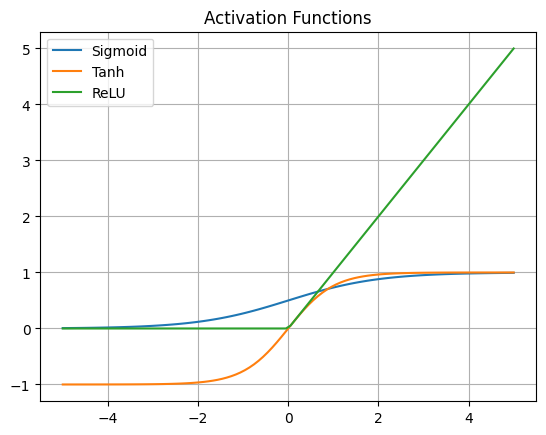

In [28]:
import torch.nn.functional as F

x = torch.linspace(-5, 5, 100)
plt.plot(x.numpy(), torch.sigmoid(x).numpy(), label='Sigmoid')
plt.plot(x.numpy(), torch.tanh(x).numpy(), label='Tanh')
plt.plot(x.numpy(), F.relu(x).numpy(), label='ReLU')
plt.title("Activation Functions")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Prepare dataset
X, y = make_classification(
    n_samples=200, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, random_state=42
)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Activation functions to compare
activations = {
    "sigmoid": torch.sigmoid,
    "tanh": torch.tanh,
    "relu": torch.relu
}

# Results tracker
results = {}

for name, activation_fn in activations.items():

    class BinaryNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(2, 4)
            self.fc2 = nn.Linear(4, 1)

        def forward(self, x):
            x = activation_fn(self.fc1(x))
            return torch.sigmoid(self.fc2(x))  # Always use sigmoid for binary output

    model = BinaryNet()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    losses = []

    # Train
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor)
        pred_labels = (preds >= 0.5).float()
        acc = (pred_labels == y_test_tensor).float().mean().item()

    results[name] = {"losses": losses, "accuracy": acc}

    print(f"{name.upper()} → Final Test Accuracy: {acc:.4f}")

SIGMOID → Final Test Accuracy: 0.8750
TANH → Final Test Accuracy: 0.8500
RELU → Final Test Accuracy: 0.8750


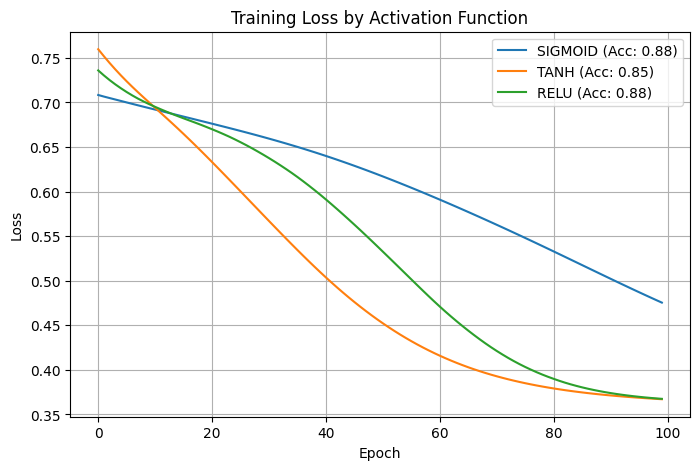

In [30]:
# Plot training losses for each activation function
plt.figure(figsize=(8, 5))
for name in results:
    plt.plot(results[name]["losses"], label=f'{name.upper()} (Acc: {results[name]["accuracy"]:.2f})')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss by Activation Function")
plt.legend()
plt.grid(True)
plt.show()

### Comparing Loss Functions

In [31]:
pred = torch.tensor([0.9, 0.1, 0.2])
target = torch.tensor([1.0, 0.0, 0.0])

mse = nn.MSELoss()(pred, target)
bce = nn.BCELoss()(pred, target)

print(f"MSE Loss: {mse.item():.4f}")
print(f"Binary Cross-Entropy Loss: {bce.item():.4f}")

MSE Loss: 0.0200
Binary Cross-Entropy Loss: 0.1446


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Dataset
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Loss functions to compare
loss_functions = {
    "BCELoss": nn.BCELoss(),
    "BCEWithLogitsLoss": nn.BCEWithLogitsLoss(),
    "MSELoss": nn.MSELoss()
}

# Results storage
results = {}

for loss_name, loss_fn in loss_functions.items():

    class BinaryNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(2, 4)
            self.fc2 = nn.Linear(4, 1)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            if loss_name == "BCEWithLogitsLoss":
                return self.fc2(x)  # raw logits
            else:
                return torch.sigmoid(self.fc2(x))  # for BCE and MSE

    model = BinaryNet()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        target = y_train_tensor
        if loss_name == "BCEWithLogitsLoss":
            loss = loss_fn(outputs, target)
            predictions = torch.sigmoid(outputs)
        else:
            loss = loss_fn(outputs, target)
            predictions = outputs
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_output = model(X_test_tensor)
        if loss_name == "BCEWithLogitsLoss":
            test_preds = torch.sigmoid(test_output)
        else:
            test_preds = test_output
        pred_labels = (test_preds >= 0.5).float()
        acc = (pred_labels == y_test_tensor).float().mean().item()

    results[loss_name] = {"losses": losses, "accuracy": acc}
    print(f"{loss_name}: Test Accuracy = {acc:.4f}")

BCELoss: Test Accuracy = 0.8500
BCEWithLogitsLoss: Test Accuracy = 0.8250
MSELoss: Test Accuracy = 0.8500


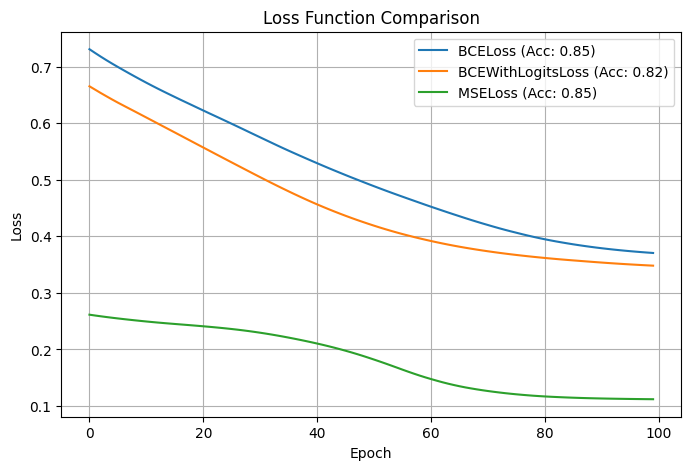

In [33]:
# Compare training losses
plt.figure(figsize=(8, 5))
for name in results:
    plt.plot(results[name]["losses"], label=f'{name} (Acc: {results[name]["accuracy"]:.2f})')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function Comparison")
plt.legend()
plt.grid(True)
plt.show()

## 3 Classifying Newswires

/Users/raminahadi/Desktop/AAA_WSs/AAA_2025/AAA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


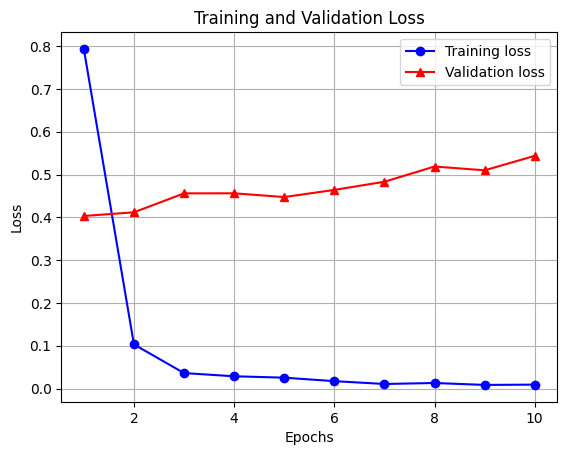

In [11]:
# PyTorch Tutorial: Text Classification with a Simple Neural Network (Using Real Dataset)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load a real dataset (AG News from Hugging Face Datasets)
dataset = load_dataset("ag_news")

# Use a subset safely using .select()
subset = dataset['train'].select(range(2000))

texts = [row['text'] for row in subset]
labels = [row['label'] for row in subset]

# Vectorize the text using bag-of-words
vectorizer = CountVectorizer(binary=True, max_features=10000)
x = vectorizer.fit_transform(texts).toarray()

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split into training and validation sets
val_size = 400
train_size = len(x_tensor) - val_size
train_ds, val_ds = random_split(TensorDataset(x_tensor, y_tensor), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Define the model
class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = TextClassifier(input_dim=x.shape[1], num_classes=len(set(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Training loop
train_losses, val_losses = [], []
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            output = model(xb)
            loss = criterion(output, yb)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

# Plotting
plt.plot(range(1, epochs + 1), train_losses, 'bo-', label='Training loss')
plt.plot(range(1, epochs + 1), val_losses, 'r^-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1: Train Loss = 1.1722, Val Loss = 0.8835
Epoch 2: Train Loss = 0.5289, Val Loss = 0.5651
Epoch 3: Train Loss = 0.2123, Val Loss = 0.4914
Epoch 4: Train Loss = 0.1014, Val Loss = 0.4877
Epoch 5: Train Loss = 0.0596, Val Loss = 0.4842
Epoch 6: Train Loss = 0.0390, Val Loss = 0.4905
Epoch 7: Train Loss = 0.0301, Val Loss = 0.5112
Epoch 8: Train Loss = 0.0230, Val Loss = 0.5140
Early stopping at epoch 8


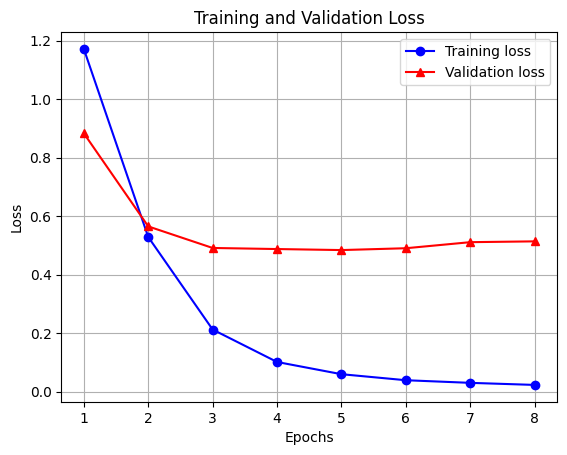

In [12]:
# PyTorch Tutorial: Text Classification with a Simple Neural Network (Using Real Dataset)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load a real dataset (AG News from Hugging Face Datasets)
dataset = load_dataset("ag_news")

# Use a subset safely using .select()
subset = dataset['train'].select(range(2000))

texts = [row['text'] for row in subset]
labels = [row['label'] for row in subset]

# Vectorize the text using bag-of-words
vectorizer = CountVectorizer(binary=True, max_features=10000)
x = vectorizer.fit_transform(texts).toarray()

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split into training and validation sets
val_size = 400
train_size = len(x_tensor) - val_size
train_ds, val_ds = random_split(TensorDataset(x_tensor, y_tensor), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Define the model
class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = TextClassifier(input_dim=x.shape[1], num_classes=len(set(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

# Training loop with early stopping
train_losses, val_losses = [], []
epochs = 50
patience = 3
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            output = model(xb)
            loss = criterion(output, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
if best_model_state:
    model.load_state_dict(best_model_state)

# Plotting
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo-', label='Training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r^-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### The Deep Neural Network Architecture
The problem at hand looks very similar to the problem we solved last week. However, instead of having 2 classes (positive and negative sentiment) we do have 46 classes. Thus, the dimensionality of the output space is much larger.

Note two things here:
1. Each input vector will be mapped to a 46d output vector
2. Last layer uses a softmax activation function. In other words, the present network will output a probability distribution 

##### The loss function
The best loss function to use in this case is categorical_crossentropy. It measures
the distance between two probability distributions: here, between the probability distribution
output by the network and the true distribution of the labels.

## Task: Experiment with layers

We have a output layer with 46 nodes. What happens to the accuracy when we reduce the number of nodes the second intermediate layer
to 1?

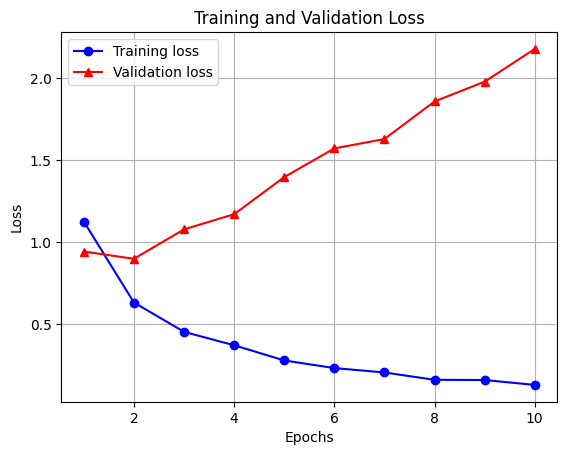

In [13]:
# PyTorch Tutorial: Text Classification with a Simple Neural Network (Using Real Dataset)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load a real dataset (AG News from Hugging Face Datasets)
dataset = load_dataset("ag_news")

# Use a subset safely using .select()
subset = dataset['train'].select(range(2000))

texts = [row['text'] for row in subset]
labels = [row['label'] for row in subset]

# Vectorize the text using bag-of-words
vectorizer = CountVectorizer(binary=True, max_features=10000)
x = vectorizer.fit_transform(texts).toarray()

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split into training and validation sets
val_size = 400
train_size = len(x_tensor) - val_size
train_ds, val_ds = random_split(TensorDataset(x_tensor, y_tensor), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Define the model
class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.fc3 = nn.Linear(1, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = TextClassifier(input_dim=x.shape[1], num_classes=len(set(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Training loop
train_losses, val_losses = [], []
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            output = model(xb)
            loss = criterion(output, yb)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

# Plotting
plt.plot(range(1, epochs + 1), train_losses, 'bo-', label='Training loss')
plt.plot(range(1, epochs + 1), val_losses, 'r^-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Task: Experiment with bag of words model
The most basic bag of words model we used assigned a 1 to any word that is in the article, but it doesn't take into account **frequencies**.

Can you think of a model that takes into account word frequencies?

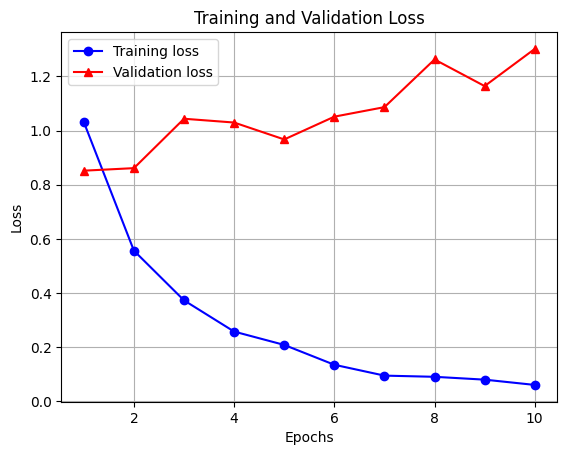

In [14]:
# PyTorch Tutorial: Text Classification with a Simple Neural Network (Using Real Dataset)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load a real dataset (AG News from Hugging Face Datasets)
dataset = load_dataset("ag_news")

# Use a subset safely using .select()
subset = dataset['train'].select(range(2000))

texts = [row['text'] for row in subset]
labels = [row['label'] for row in subset]

# Vectorize the text using bag-of-words
vectorizer = CountVectorizer(binary=False, max_features=10000)
x = vectorizer.fit_transform(texts).toarray()

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split into training and validation sets
val_size = 400
train_size = len(x_tensor) - val_size
train_ds, val_ds = random_split(TensorDataset(x_tensor, y_tensor), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Define the model
class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.fc3 = nn.Linear(1, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = TextClassifier(input_dim=x.shape[1], num_classes=len(set(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Training loop
train_losses, val_losses = [], []
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            output = model(xb)
            loss = criterion(output, yb)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

# Plotting
plt.plot(range(1, epochs + 1), train_losses, 'bo-', label='Training loss')
plt.plot(range(1, epochs + 1), val_losses, 'r^-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Solution

### Take-Home Message:

1. N Classes => N Output Nodes
2. Output Layer should be a SoftMAX Activation function (provided that you want to a assign each data point to ONE class)
3. Categorical Crossentropy is in many cases the loss function you should use for classification
4. Avoid Information Bottlenecks (i.e., don't use hidden layers with too few nodes)
5. Pre-processing inputs in a clever way can be more important than network tuning!

## 4 Regression with Deep Learning

In [15]:
# PyTorch version of California Housing regression with k-fold cross-validation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load California Housing data (replacement for deprecated Boston housing)
housing = fetch_california_housing()
data = housing.data
targets = housing.target

# Standardize features
scaler = StandardScaler()
data = scaler.fit_transform(data)
targets = targets.astype(np.float32)

# Convert to PyTorch tensors
x_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(x_tensor, y_tensor)

# Define model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# K-fold cross-validation
k = 4
num_epochs = 10
batch_size = 16
all_scores = []
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Processing fold #{fold}")
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    model = RegressionModel(input_dim=data.shape[1])
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        val_losses = [F.l1_loss(model(xb), yb, reduction='mean').item() for xb, yb in val_loader]
    all_scores.append(np.mean(val_losses))

print("MAE for each fold:", all_scores)
print("Average MAE:", np.mean(all_scores))

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
MAE for each fold: [0.37214288085514546, 0.37498082850278347, 0.40083169632651855, 0.38407523228841667]
Average MAE: 0.383007659493216


Processing fold #0
Processing fold #1


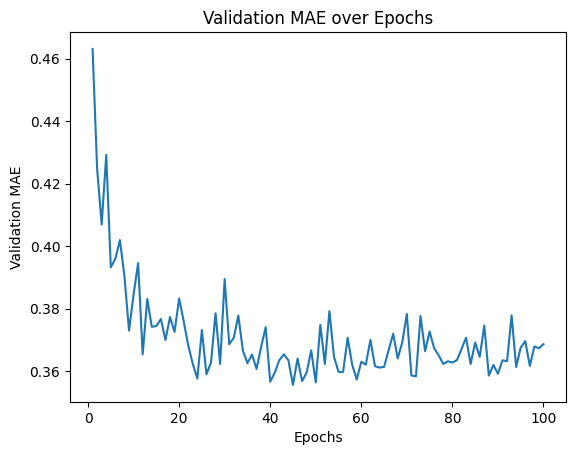

Final MAE on full dataset: 0.3071797788143158


In [16]:
# Advanced: track MAE history per epoch
k = 2
num_epochs = 100
all_mae_histories = []

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Processing fold #{fold}")
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=1)

    model = RegressionModel(input_dim=data.shape[1])
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    mae_history = []
    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # MAE on validation set
        model.eval()
        with torch.no_grad():
            mae = [F.l1_loss(model(xb), yb, reduction='mean').item() for xb, yb in val_loader]
        mae_history.append(np.mean(mae))

    all_mae_histories.append(mae_history)

# Average MAE per epoch
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Plot
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Validation MAE over Epochs")
plt.show()

# Final evaluation on full dataset (simulate Keras approach)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = RegressionModel(input_dim=data.shape[1])
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(80):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    preds = model(x_tensor)
    final_mae = F.l1_loss(preds, y_tensor).item()

print("Final MAE on full dataset:", final_mae)

PyTorch Final MAE: 0.30875363945961
XGBoost Final MAE: 0.34675970673561096


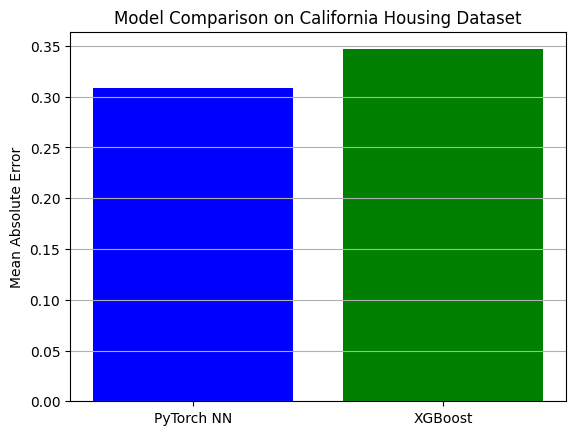

In [17]:
# PyTorch and XGBoost comparison for California Housing regression

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Load California Housing data
housing = fetch_california_housing()
data = housing.data
targets = housing.target

# Standardize features
scaler = StandardScaler()
data = scaler.fit_transform(data)
targets = targets.astype(np.float32)

# Convert to PyTorch tensors
x_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(x_tensor, y_tensor)

# Define PyTorch model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Train final PyTorch model
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
model = RegressionModel(input_dim=data.shape[1])
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(80):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    preds = model(x_tensor)
    pytorch_mae = F.l1_loss(preds, y_tensor).item()

print("PyTorch Final MAE:", pytorch_mae)

# XGBoost regression
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred)

print("XGBoost Final MAE:", xgb_mae)

# Comparison Plot
methods = ['PyTorch NN', 'XGBoost']
mae_scores = [pytorch_mae, xgb_mae]

plt.bar(methods, mae_scores, color=['blue', 'green'])
plt.ylabel("Mean Absolute Error")
plt.title("Model Comparison on California Housing Dataset")
plt.grid(True, axis='y')
plt.show()


#### Take-Home Message
1. Mean squared error (MSE) is a loss function commonly used for regression.
2. A common regression metric is mean absolute error.
3. When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
4. When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
5. If there is little data, use small network. Otherwise your network might overfit.